# Predicting Heart Disease

The [World Health Organization (WHO)](https://www.who.int/health-topics/cardiovascular-diseases) estimates that 17.9 million people die from cardiovascular diseases (CVDs) every year. There are multiple risk factors that could contribute to CVD in an individual, such as unhealthy diet, lack of physical activity, or mental illness. Identifying these risk factors early on could help prevent many premature deaths.

Here we work with an anoymized [dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction) that includes relevant information for each patient, such as their personal information and some medical data, including whether or not they have had heart disease before. We are tasked with using the dataset to accurately predict the likelihood of a new patient having heart disease in the future.

## Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

Read data into pandas dataframe and display first five rows.

In [2]:
hd_data = pd.read_csv('heart_disease_prediction.csv')
hd_data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


A quick look at dataset info (columns, entry counts, and data types).

In [3]:
hd_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Column descriptions are included in the dataset link above.
There are 918 entries in the dataset with no missing values.

**Note: FastingBS and HeartDisease (our target variable) have dtype int64 but are also categorical variables, since they only take the values 0 or 1.**

### EDA: Descriptive Statistics

Starting with exploring and analyzing the numerical columns:

In [4]:
hd_data.describe(include=np.number)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Some observations:
- The mean patient Age in this dataset is 53 (std = 9), The youngest is 28 and the oldest is 77.
- The median for Cholesterol is higher than its mean by roughly 25 mm/dl, indicating that it could be a left-skewed distribution indicating possible outliers skewing the distribution.
- RestingBP and Cholesterol have a minumum value of zero (these values are unlikely.)
- FastingBS and HeartDisease are categorical (0 or 1) ; FastingBS has more 0 values, while HeartDisease is almost equally distrubted.

In summary, the distrubtion of RestingBP and Cholesterol values may require a closer look due to outlier and unlikely zero values.

### EDA: Visualizations

How is the dataset distributed in relation to our target variable (Heart Disease)? For example how many a resting ECG catergorized as ST? How many female patients had heart disease?

In [5]:
hd_data.describe(include=object)

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


Here we can see the number of unique categories for each feature, the top category, and its frequency. One quick observation is that dataset consists of patients that are mostly male (725 of 918 total).

Will will explore the categorical features using visualization to understand how the data is distributed. For this we will leverage the seaborn countplot method:

In [6]:
cat_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS', 'HeartDisease']

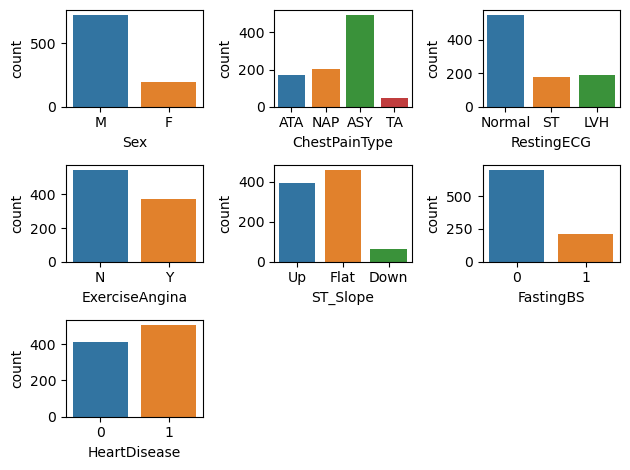

In [7]:
fig, axes = plt.subplots(3,3) # Define subplot space

#For each categorical feature, plot a bar chart displaying the number of values for each category:
for name, ax in zip(cat_cols, axes.flatten()):
    sns.countplot(x=name, data=hd_data, ax=ax)
        
axes[2,1].remove() # Remove uneeded subplots
axes[2,2].remove()  
plt.tight_layout() # Adjusts subplot params so that the subplot(s) fits in to the figure area.      
plt.show()

As we discovered above, the patients in this datasent consist of mostly men, which could lead to bias in our model. In addition:
- Chest pain type is majority Asympotomatic (ASY)
- Resting ECG is majority Normal
- Exericise-induced animga is majority NO
- Downsloping (DOWN) is not highly represented in ST_slope

And we were aware of the distrubtion of fasting blood sugar and the heart disease diagnosis from our descriptive analysis above.

Next we will group these categories by by our output label, HeartDisease:

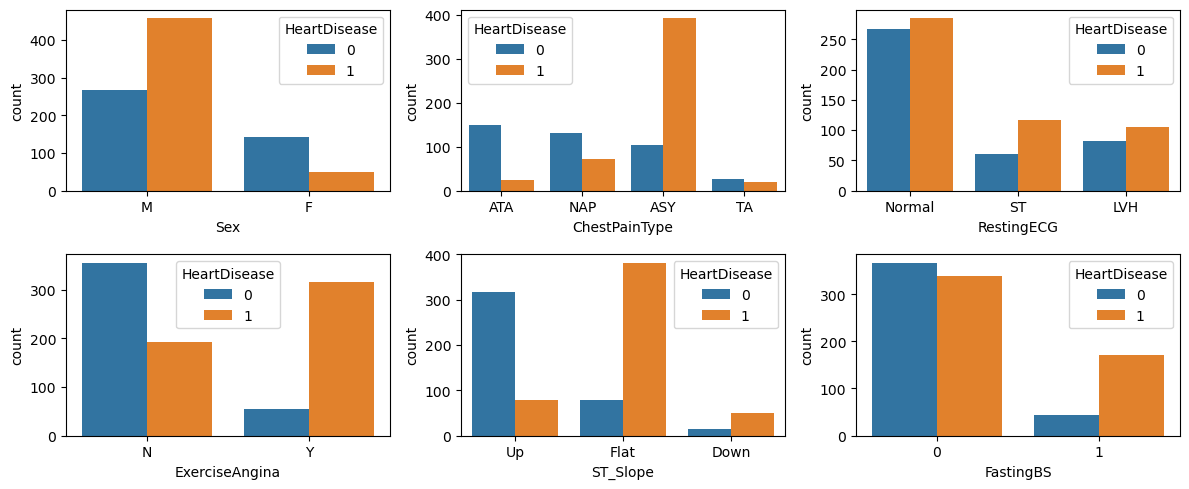

In [8]:
fig, axes = plt.subplots(2,3, figsize=(12,5)) # Define subplot space, and increase figure size.

#For each categorical feature, plot a bar chart displaying the number of values for each category:
for name, ax in zip(cat_cols[:-1], axes.flatten()):
    sns.countplot(x=name, data=hd_data, ax=ax, hue="HeartDisease")
        
# axes[2,1].remove() # Remove uneeded subplots
# axes[2,2].remove()  
plt.tight_layout() # Adjusts subplot params so that the subplot(s) fits in to the figure area.      
plt.show()

Some observations:
- Men have a higher rate of heart disease then women.
- Asymptomatic (ASY) chest pain type has a higher count of patents with heart disease
- Those with Exericise-induced anigma have a higher prevalence of heart disease
- High fasting blood sugar (1) have high diagnois of heart disease

Some additonal groupings that could be explored:
- What percentage of patients with heart disease are male and over 50 years old?
- What is the median age of patiens who were diagnosed with heart disease?

## Data Cleaning

There are a lot of similar patterns that we can observe when we start grouping our data. These patterns can help us narrow down the features we want for training our model.

Before we move on to that, let's clean up the data. We identified that there are no missing values. However, as we noticed earlier, a couple of columns have 0 values that don't make sense. We will identify how many of these values exist in our dataset and approach accordingly:

In [9]:
hd_data[hd_data['RestingBP'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [10]:
hd_data[hd_data['Cholesterol'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


There is 1 row that has a value of 0 for RestingBP and 172 rows that have value of 0 for Cholesterol. 

Given the small fraction of errorenous data for resting BP (1/918) we will simply remove it from the dataset:

In [11]:
hd_data = hd_data[hd_data['RestingBP'] != 0]

But beacause a sizeable portion of the Cholesterol data is erroneous (172/918), we will replace those values with the median value of the Cholesterol, based on the HeartDisease grouping:

In [12]:
med_chol_by_hd = hd_data[['Cholesterol', 'HeartDisease']].groupby('HeartDisease').median()['Cholesterol'] # Find median values by group
med_chol_by_hd

HeartDisease
0    227.0
1    217.0
Name: Cholesterol, dtype: float64

In [13]:
# Break values into series
Cholesterol = hd_data['Cholesterol'].copy() 
HeartDisease = hd_data['HeartDisease'].copy()

In [14]:
# Find and replace appropriate values
for i, row in enumerate(zip(Cholesterol, HeartDisease)):
    if row[0] == 0:
        if row[1] != 1:
            Cholesterol.iloc[i] = med_chol_by_hd[0]
        else:
            Cholesterol.iloc[i] = med_chol_by_hd[1]
            
hd_data['Cholesterol'] = Cholesterol
            

In [15]:
print(sum(hd_data['Cholesterol'] == 0), 'remaining zero values')
print(hd_data.shape)

0 remaining zero values
(917, 12)


There are no remaining zero values and we have removed the single erronoeous heart disease value.

## Feature Selection

Now that we've cleaned our data, we can select features for our model. 

We'll also explore how the columns correlate to one another. Before we attempt that, we'll convert our categorical columns into dummy variables:

In [16]:
cat_features = cat_cols[:-2] # without the columns that are already 0 or 1
cat_features

['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

In [17]:
hd_data = pd.get_dummies(data = hd_data, columns=cat_features) # Convert categorical variable into dummy/indicator variables.

In [18]:
hd_data.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,1,0,0,...,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,0,1,0,...,0,0,0,0,1,1,0,0,0,1
3,48,138,214,0,108,1.5,1,1,0,1,...,0,0,0,1,0,0,1,0,1,0
4,54,150,195,0,122,0.0,0,0,1,0,...,1,0,0,1,0,1,0,0,0,1


Explore how these columns are related with Pearson's correlation (squared)

In [19]:
hd_corr = hd_data.corr() 
hd_corr**2

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
Age,1.000000,0.069213,0.000716,0.039271,0.146138,0.066855,0.079531,0.003099,0.003099,0.027857,...,0.000136,0.001029,0.021268,0.053265,0.018742,0.046664,0.046664,0.019169,0.034410,0.066578
RestingBP,0.069213,1.000000,0.008495,0.004600,0.012033,0.030364,0.013922,0.000089,0.000089,0.001728,...,0.000758,0.002447,0.002565,0.012941,0.007949,0.023429,0.023429,0.000107,0.012138,0.011230
Cholesterol,0.000716,0.008495,1.000000,0.000572,0.001441,0.003259,0.000621,0.017495,0.017495,0.001988,...,0.002831,0.001465,0.010866,0.002130,0.002427,0.003379,0.003379,0.000653,0.004624,0.003092
FastingBS,0.039271,0.004600,0.000572,1.000000,0.017179,0.002816,0.071821,0.014502,0.014502,0.017064,...,0.001459,0.000716,0.000143,0.008572,0.016092,0.003599,0.003599,0.011017,0.011596,0.026356
MaxHR,0.146138,0.012033,0.001441,0.017179,1.000000,0.025989,0.161130,0.035974,0.035974,0.125630,...,0.017798,0.010047,0.015937,0.000537,0.024826,0.136917,0.136917,0.005348,0.118089,0.147717
Oldpeak,0.066855,0.030364,0.003259,0.002816,0.025989,1.000000,0.162924,0.011119,0.011119,0.078925,...,0.011581,0.001049,0.007593,0.013758,0.003168,0.167685,0.167685,0.103923,0.080018,0.202769
HeartDisease,0.079531,0.013922,0.000621,0.071821,0.161130,0.162924,1.000000,0.093097,0.093097,0.268675,...,0.046359,0.002980,0.000125,0.008547,0.010623,0.245510,0.245510,0.015093,0.306584,0.386688
Sex_F,0.003099,0.000089,0.017495,0.014502,0.035974,0.011119,0.093097,1.000000,1.000000,0.034089,...,0.004581,0.000015,0.002425,0.000123,0.004097,0.036567,0.036567,0.004383,0.013362,0.022661
Sex_M,0.003099,0.000089,0.017495,0.014502,0.035974,0.011119,0.093097,1.000000,1.000000,0.034089,...,0.004581,0.000015,0.002425,0.000123,0.004097,0.036567,0.036567,0.004383,0.013362,0.022661
ChestPainType_ASY,0.027857,0.001728,0.001988,0.017064,0.125630,0.078925,0.268675,0.034089,0.034089,1.000000,...,0.332847,0.062221,0.000003,0.003932,0.005763,0.184466,0.184466,0.010641,0.093139,0.130213


Plotting relationship with a heatmap of the r squared values:

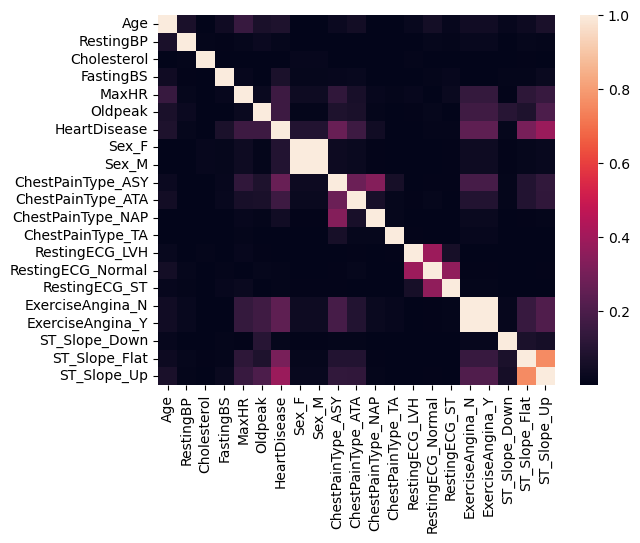

In [20]:
sns.heatmap(hd_corr**2) # Plot square of Pearson correlation coefficient (r squared)
plt.show()

In [21]:
# Sort the r_sqaured values to easily identify features
(hd_corr['HeartDisease']**2).sort_values(ascending = False)

HeartDisease         1.000000
ST_Slope_Up          0.386688
ST_Slope_Flat        0.306584
ChestPainType_ASY    0.268675
ExerciseAngina_Y     0.245510
ExerciseAngina_N     0.245510
Oldpeak              0.162924
ChestPainType_ATA    0.161346
MaxHR                0.161130
Sex_F                0.093097
Sex_M                0.093097
Age                  0.079531
FastingBS            0.071821
ChestPainType_NAP    0.046359
ST_Slope_Down        0.015093
RestingBP            0.013922
RestingECG_ST        0.010623
RestingECG_Normal    0.008547
ChestPainType_TA     0.002980
Cholesterol          0.000621
RestingECG_LVH       0.000125
Name: HeartDisease, dtype: float64

We could select the top features from this list, but let's try feature selection by perfroming a logistic regression with L1 regularization. The goal will be to select features based on the absolute value of their coefficients.

From the sklearn documentation: Linear models penalized with the L1 norm have sparse solutions: many of their estimated coefficients are zero. When the goal is to reduce the dimensionality of the data to use with another classifier, they can be used along with SelectFromModel to select the non-zero coefficients. 

In [22]:
feature_data = hd_data.drop('HeartDisease', axis=1).copy()
label_data = hd_data['HeartDisease'].copy()

In [23]:
selection = SelectFromModel(LogisticRegression(random_state = 42, C=0.1, penalty='l1', solver='liblinear')).fit(feature_data, label_data)
    # the parameter C controls the sparsity: the smaller C the fewer features selected
    # the solver 'liblinear' is needed for the 'l1' penalty


In [24]:
selection.get_feature_names_out()

array(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
       'Sex_F', 'ChestPainType_ASY', 'ExerciseAngina_N', 'ST_Slope_Flat',
       'ST_Slope_Up'], dtype=object)

Our feature selection with sklearn determined that the above features are the most salient predictors of heart disease. Cholesterol is included in this group, which is interesting as the person correlation with heart disease was low. 



## Building a Classifier

We will see how a KNN model performs with these features:


In [25]:
features = selection.get_feature_names_out()

In [26]:
X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=0.33, random_state=42)

In [27]:
neigh = KNeighborsClassifier(n_neighbors=3)

In [28]:
for feature in X_train[features]:
    neigh.fit(X_train[[feature]], y_train)
    print(feature, 'score:', neigh.score(X_test[[feature]], y_test))

Age score: 0.5412541254125413
RestingBP score: 0.5082508250825083
Cholesterol score: 0.6402640264026402
FastingBS score: 0.6006600660066007
MaxHR score: 0.6270627062706271
Oldpeak score: 0.6435643564356436
Sex_F score: 0.6006600660066007
ChestPainType_ASY score: 0.7755775577557755
ExerciseAngina_N score: 0.7128712871287128
ST_Slope_Flat score: 0.6006600660066007
ST_Slope_Up score: 0.7920792079207921


ST_Slope_Up performed the best on this KNN classifier with a score of 0.79

Now let's train a model on all of these features together. Before we do, it's important to note that our features are not yet normalized. We will first scale our data to the range (0, 1) before training our model. Note: We will only scale our selected features.

In [29]:
scaler = MinMaxScaler()

In [30]:
X_train_ = scaler.fit(X_train[features]).transform(X_train[features])
X_test_ = scaler.fit(X_test[features]).transform(X_test[features])

In [31]:
X_train_

array([[0.5       , 0.28301887, 0.30501931, ..., 0.        , 1.        ,
        0.        ],
       [0.60416667, 0.43396226, 0.18146718, ..., 1.        , 0.        ,
        1.        ],
       [0.9375    , 0.5754717 , 0.43436293, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.75      , 0.1509434 , 0.31467181, ..., 1.        , 0.        ,
        1.        ],
       [0.64583333, 0.54716981, 0.27413127, ..., 0.        , 0.        ,
        1.        ],
       [0.22916667, 0.52830189, 0.59266409, ..., 1.        , 1.        ,
        0.        ]])

In [32]:
neigh2 = KNeighborsClassifier(n_neighbors=3).fit(X_train_, y_train)
score = neigh2.score(X_test_, y_test)
print('Model with selected features:', score)


Model with selected features: 0.834983498349835


This new model that includes scaled features performs marginally better than our initial model with a single feature (0.835 vs 0.792).

Now that we have a reasonably well-performing model, we can experiment with the parameters and hyperparameters. We'll use GridSearchCV to search over those values. Since GridSearchCV creates a validation set as part of its process, we'll have to update our workflow a bit.

In [33]:
parameters = {'n_neighbors': (3,5,7), 'weights': ('uniform', 'distance')} # paremeters that we want to search over 

In [34]:
neigh_CV= KNeighborsClassifier()

In [ ]:
clf = GridSearchCV(neigh_CV, parameters, scoring = 'accuracy')
clf.fit(X_train_, y_train)

In [36]:
print('best params:', clf.best_params_, 'best score:', clf.best_score_)

best params: {'n_neighbors': 7, 'weights': 'distance'} best score: 0.8387311741969878


The best parameters listed above resulted in a score of 0.837, once again marginally better than our previous model score of 0.835.

We'll now evaluate this model with our best paramaters on our test set:

In [ ]:
# clf.best_estimator_

In [38]:
clf.score(X_test_, y_test)

0.8448844884488449

Our model got an accuracy of ~84%!

Our result above raises a question, however. How can the model perform better on the test set compared to the validation set? One explanation comes from looking at how the data is distributed. We used Sex, an unequally distributed feature, as one of our features for training the model.

We know that that the above datasets have a significantly higher number of male patients than female ones. This imbalance could present a bias in our dataset and it potentially impacts our model. If the test dataset doesn't have many female patients and the model was trained on a dataset with more male patients, then it is understandable that the test set has better accuracy.

Another similar issue is age. Above were described some questions that could be asked about age:
- What percentage of patients with heart disease are male and over 50 years old?
- What is the median age of patiens who were diagnosed with heart disease?

This could be another factor that influences the model and could be explored.

Also, here we only enlisted a single algorithm. A different algorithm could improve our model. One approach would be to enlist an ensemble of algorithms and perform a grid search with all of them to find the algorithm that serves as the best classifer.